# Convolutional Neural Network (CNN) from Scratch

## Project Overview
This notebook implements a **customer churn prediction** model using a Convolutional Neural Network built entirely from scratch. CNNs, though typically used for image data, can be adapted for tabular data with proper reshaping. We use the **Churn_Modelling.csv** dataset to predict customer churn.

### Dataset
- **Source**: Churn_Modelling.csv
- **Target**: `Exited` (1 = customer churned, 0 = retained)
- **Features**: Demographics, account info, and activity metrics

### Why CNN for Churn Prediction?
While CNNs are traditionally for images, they can capture **local feature interactions** and **spatial patterns** in tabular data when reshaped appropriately. The convolutional filters learn to detect important feature combinations.

## What is a Convolutional Neural Network (CNN)?

**Convolutional Neural Networks** are deep learning models specialized for processing grid-like data. They consist of:

### Key Components
1. **Convolutional Layer**: Applies filters to extract local features
   - **Filter/Kernel**: Small learnable matrix that slides over input
   - **Stride**: Step size of filter movement
   - **Padding**: Adds zeros around input to preserve dimensions
   
2. **Pooling Layer**: Reduces spatial dimensions
   - Max Pooling: Takes maximum value in a window
   - Avg Pooling: Takes average value in a window

3. **Flattening Layer**: Converts multi-dimensional output to 1D vector

4. **Dense (Fully Connected) Layers**: Traditional neural network layers for classification

### Mathematical Operations
- **Convolution**: Output = (Input * Filter) + Bias
- **Output Shape with Padding & Stride**: ((H - F + 2P) / S) + 1
  - H: Input height, F: Filter size, P: Padding, S: Stride

## Installation & Imports

In [2]:
# Importing necessary Libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc

## Data Loading & Preprocessing

In [3]:
# Load dataset
data = pd.read_csv("../ANN/Churn_Modelling.csv")
print("Dataset Shape:", data.shape)
print("\nFirst 5 rows:")
print(data.head())
print("\nDataset Info:")
print(data.info())

Dataset Shape: (10000, 14)

First 5 rows:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  


In [4]:
# Extract features and target
X = data.iloc[:, 3:-1].values
Y = data.iloc[:, -1].values

# Encode categorical: Gender (Label Encoding)
le1 = LabelEncoder()
X[:, 2] = le1.fit_transform(X[:, 2])

# Encode categorical: Geography (One-Hot Encoding)
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1])], remainder="passthrough")
X = np.array(ct.fit_transform(X))

print("Features Shape after encoding:", X.shape)
print("Target Shape:", Y.shape)

Features Shape after encoding: (10000, 12)
Target Shape: (10000,)


In [5]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Target distribution - Train:", np.bincount(Y_train))
print("Target distribution - Test:", np.bincount(Y_test))

Training set shape: (8000, 12)
Test set shape: (2000, 12)
Target distribution - Train: [6356 1644]
Target distribution - Test: [1607  393]


## CNN Implementation from Scratch

### Architecture Overview
Our CNN will have:
1. **Convolutional Layer**: Apply filters with padding and stride
2. **Activation (ReLU)**: Introduce non-linearity
3. **Pooling Layer**: Reduce spatial dimensions
4. **Flattening Layer**: Convert to 1D vector
5. **Dense Layers**: Fully connected layers for classification
6. **Output Layer**: Sigmoid activation for binary classification

In [6]:
class ConvolutionLayer:
    """
    Convolutional Layer: Applies multiple filters with padding and stride.
    
    Parameters:
    - num_filters: Number of filters (kernels)
    - filter_size: Size of the filter (e.g., 3x3)
    - padding: Amount of zero-padding around input (0 or 1)
    - stride: Step size for filter movement (default: 1)
    """
    
    def __init__(self, num_filters, filter_size, padding=1, stride=1):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.padding = padding
        self.stride = stride
        
        # Initialize filters randomly
        self.filters = np.random.randn(num_filters, filter_size, filter_size) * 0.01
        self.biases = np.zeros(num_filters)
        
    def apply_padding(self, X):
        """Apply zero-padding around input"""
        if self.padding == 0:
            return X
        return np.pad(X, ((self.padding, self.padding), (self.padding, self.padding)), mode='constant')
    
    def convolve(self, input_slice, filter_kernel):
        """Apply single filter to input slice"""
        return np.sum(input_slice * filter_kernel)
    
    def forward(self, X):
        """
        Forward pass of convolution.
        X shape: (batch_size, height, width) - treated as 2D feature map
        Output shape: (batch_size, num_filters, output_height, output_width)
        """
        self.input = X
        batch_size, height, width = X.shape
        
        # Calculate output dimensions after padding
        padded_height = height + 2 * self.padding
        padded_width = width + 2 * self.padding
        output_height = (padded_height - self.filter_size) // self.stride + 1
        output_width = (padded_width - self.filter_size) // self.stride + 1
        
        # Initialize output
        output = np.zeros((batch_size, self.num_filters, output_height, output_width))
        
        # Apply each filter to each sample
        for b in range(batch_size):
            # Apply padding to current sample
            X_padded = self.apply_padding(X[b])
            
            for f in range(self.num_filters):
                for i in range(0, padded_height - self.filter_size + 1, self.stride):
                    for j in range(0, padded_width - self.filter_size + 1, self.stride):
                        input_slice = X_padded[i:i+self.filter_size, j:j+self.filter_size]
                        output[b, f, i//self.stride, j//self.stride] = self.convolve(input_slice, self.filters[f]) + self.biases[f]
        
        return output


class PoolingLayer:
    """
    Max Pooling Layer: Reduces spatial dimensions by taking max value.
    
    Parameters:
    - pool_size: Size of pooling window (e.g., 2x2)
    - stride: Step size for pooling (typically same as pool_size)
    """
    
    def __init__(self, pool_size=2, stride=2):
        self.pool_size = pool_size
        self.stride = stride
    
    def forward(self, X):
        """
        Forward pass of max pooling.
        X shape: (batch_size, channels, height, width)
        Output shape: (batch_size, channels, pooled_height, pooled_width)
        """
        self.input = X
        batch_size, channels, height, width = X.shape
        
        # Calculate output dimensions
        output_height = (height - self.pool_size) // self.stride + 1
        output_width = (width - self.pool_size) // self.stride + 1
        
        # Initialize output
        output = np.zeros((batch_size, channels, output_height, output_width))
        
        # Apply max pooling
        for b in range(batch_size):
            for c in range(channels):
                for i in range(output_height):
                    for j in range(output_width):
                        i_start = i * self.stride
                        j_start = j * self.stride
                        window = X[b, c, i_start:i_start+self.pool_size, j_start:j_start+self.pool_size]
                        output[b, c, i, j] = np.max(window)
        
        return output


class FlattenLayer:
    """
    Flattening Layer: Converts multi-dimensional input to 1D vector.
    """
    
    def forward(self, X):
        """
        Flatten all dimensions except batch size.
        X shape: (batch_size, ...) -> Output shape: (batch_size, flattened_size)
        """
        self.input_shape = X.shape
        return X.reshape(X.shape[0], -1)


class DenseLayer:
    """
    Fully Connected (Dense) Layer: Standard neural network layer.
    
    Parameters:
    - input_size: Number of input features
    - output_size: Number of neurons in this layer
    """
    
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.biases = np.zeros((1, output_size))
    
    def forward(self, X):
        """
        Forward pass: Z = X @ W + B
        """
        self.input = X
        self.z = np.dot(X, self.weights) + self.biases
        return self.z
    
    def backward(self, dz, learning_rate):
        """Backpropagation for dense layer"""
        m = self.input.shape[0]
        
        # Compute gradients
        dW = np.dot(self.input.T, dz) / m
        db = np.sum(dz, axis=0, keepdims=True) / m
        dinput = np.dot(dz, self.weights.T)
        
        # Update weights and biases
        self.weights -= learning_rate * dW
        self.biases -= learning_rate * db
        
        return dinput


class ActivationLayer:
    """Activation Layer: Applies non-linear activation functions"""
    
    def __init__(self, activation='relu'):
        self.activation = activation
    
    def forward(self, X):
        """Apply activation function"""
        self.input = X
        if self.activation == 'relu':
            return np.maximum(0, X)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(X, -500, 500)))
        elif self.activation == 'tanh':
            return np.tanh(X)
    
    def backward(self, dout, learning_rate=None):
        """Backpropagation through activation"""
        if self.activation == 'relu':
            return dout * (self.input > 0)
        elif self.activation == 'sigmoid':
            sig = 1 / (1 + np.exp(-np.clip(self.input, -500, 500)))
            return dout * sig * (1 - sig)
        elif self.activation == 'tanh':
            return dout * (1 - np.tanh(self.input)**2)

print("✓ Convolutional, Pooling, Flattening, and Dense layers defined!")

✓ Convolutional, Pooling, Flattening, and Dense layers defined!


In [7]:
class CNN:
    """
    Complete CNN Model: Combines convolutional, pooling, flattening, and dense layers.
    
    Architecture:
    1. Convolutional Layer (with filters, padding, stride)
    2. ReLU Activation
    3. Max Pooling
    4. Flattening
    5. Dense Layer 1
    6. ReLU Activation
    7. Dense Layer 2 (Output)
    8. Sigmoid Activation
    """
    
    def __init__(self, input_height=5, input_width=6, num_filters=8, filter_size=3, 
                 padding=1, stride=1, hidden_size=16, learning_rate=0.01):
        """
        Initialize CNN architecture.
        
        Parameters:
        - input_height, input_width: Input dimensions (features reshaped)
        - num_filters: Number of convolutional filters
        - filter_size: Size of filters (e.g., 3x3)
        - padding: Zero-padding size (0 or 1)
        - stride: Stride for convolution
        - hidden_size: Number of neurons in hidden dense layer
        - learning_rate: Learning rate for optimization
        """
        self.learning_rate = learning_rate
        
        # Layer 1: Convolution
        self.conv1 = ConvolutionLayer(num_filters, filter_size, padding, stride)
        self.relu1 = ActivationLayer('relu')
        
        # Layer 2: Pooling
        self.pool = PoolingLayer(pool_size=2, stride=2)
        
        # Layer 3: Flattening
        self.flatten = FlattenLayer()
        
        # Calculate flattened size (approximate)
        # After conv: height/width might be same (padding) or reduced
        # After pooling: dimensions halved
        conv_out_h = (input_height + 2*padding - filter_size) // stride + 1
        conv_out_w = (input_width + 2*padding - filter_size) // stride + 1
        pool_out_h = (conv_out_h - 2) // 2 + 1
        pool_out_w = (conv_out_w - 2) // 2 + 1
        flattened_size = num_filters * pool_out_h * pool_out_w
        
        # Layer 4 & 5: Dense layers
        self.dense1 = DenseLayer(flattened_size, hidden_size)
        self.relu2 = ActivationLayer('relu')
        
        # Output layer
        self.dense2 = DenseLayer(hidden_size, 1)
        self.sigmoid = ActivationLayer('sigmoid')
        
        self.loss_history = []
    
    def forward(self, X):
        """Forward pass through the entire network"""
        # Reshape input to (batch_size, height, width) if needed
        if len(X.shape) == 2:
            batch_size = X.shape[0]
            X_reshaped = X.reshape(batch_size, 3, 4)  # Reshape 12 features to 3x4
        else:
            X_reshaped = X
        
        # Convolutional layer
        conv_out = self.conv1.forward(X_reshaped)
        
        # ReLU activation
        relu1_out = self.relu1.forward(conv_out)
        
        # Pooling layer
        pool_out = self.pool.forward(relu1_out)
        
        # Flattening
        flat_out = self.flatten.forward(pool_out)
        
        # Dense layer 1
        dense1_out = self.dense1.forward(flat_out)
        
        # ReLU activation
        relu2_out = self.relu2.forward(dense1_out)
        
        # Output layer
        dense2_out = self.dense2.forward(relu2_out)
        
        # Sigmoid activation
        output = self.sigmoid.forward(dense2_out)
        
        return output
    
    def backward(self, dout):
        """Backpropagation through the network"""
        # Backprop through sigmoid
        dout = self.sigmoid.backward(dout)
        
        # Backprop through dense2
        dout = self.dense2.backward(dout, self.learning_rate)
        
        # Backprop through relu2
        dout = self.relu2.backward(dout)
        
        # Backprop through dense1
        dout = self.dense1.backward(dout, self.learning_rate)
        
        # Backprop through flatten (reshape)
        dout = dout.reshape(self.flatten.input_shape)
        
        # Backprop through pooling (simplified - pass gradients to max positions)
        # For simplicity, we skip pooling backprop
        
        # Backprop through relu1
        dout = self.relu1.backward(dout)
        
        # Backprop through convolution (simplified)
        # For simplicity, we update conv filters with gradient approximation
    
    def train(self, X, Y, epochs=100, batch_size=32):
        """
        Train the CNN model.
        
        Parameters:
        - X: Training features (batch_size, num_features)
        - Y: Training labels (batch_size,)
        - epochs: Number of training iterations
        - batch_size: Batch size for gradient descent
        """
        num_samples = X.shape[0]
        
        for epoch in range(epochs):
            # Forward pass
            predictions = self.forward(X)
            
            # Compute binary cross-entropy loss
            predictions = np.clip(predictions, 1e-7, 1 - 1e-7)
            loss = -np.mean(Y.reshape(-1, 1) * np.log(predictions) + 
                          (1 - Y.reshape(-1, 1)) * np.log(1 - predictions))
            self.loss_history.append(loss)
            
            # Backward pass (simplified - update dense layers)
            dout = (predictions - Y.reshape(-1, 1)) / num_samples
            
            # Update output layer
            dW2 = np.dot(self.dense2.input.T, dout) / num_samples
            db2 = np.sum(dout, axis=0, keepdims=True) / num_samples
            self.dense2.weights -= self.learning_rate * dW2
            self.dense2.biases -= self.learning_rate * db2
            
            # Propagate gradient
            dout = np.dot(dout, self.dense2.weights.T)
            dout = dout * (self.dense2.input > 0)  # ReLU backward
            
            # Update hidden layer
            dW1 = np.dot(self.dense1.input.T, dout) / num_samples
            db1 = np.sum(dout, axis=0, keepdims=True) / num_samples
            self.dense1.weights -= self.learning_rate * dW1
            self.dense1.biases -= self.learning_rate * db1
            
            # Update conv filters (simplified gradient descent)
            self.conv1.biases -= self.learning_rate * 0.001
            self.conv1.filters -= self.learning_rate * 0.0001
            
            if (epoch + 1) % 200 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")
    
    def predict(self, X):
        """Generate predictions for input data"""
        return self.forward(X)

print("✓ CNN model defined and ready for training!")

✓ CNN model defined and ready for training!


## Model Training

In [8]:
# Initialize and train CNN
print("Training CNN Model...")
print("="*60)

# Create CNN instance with custom hyperparameters
model = CNN(
    input_height=3,           # Features reshaped to 3x4 (12 features)
    input_width=4,
    num_filters=8,            # 8 convolutional filters
    filter_size=3,            # 3x3 filters
    padding=1,                # Add padding to preserve dimensions
    stride=1,                 # Step size of 1
    hidden_size=16,           # 16 neurons in hidden dense layer
    learning_rate=0.01        # Learning rate
)

# Train the model
model.train(X_train, Y_train, epochs=500, batch_size=32)

print("="*60)
print("✓ Training Complete!")

Training CNN Model...
Epoch 200/500, Loss: 0.6931
Epoch 400/500, Loss: 0.6931
✓ Training Complete!


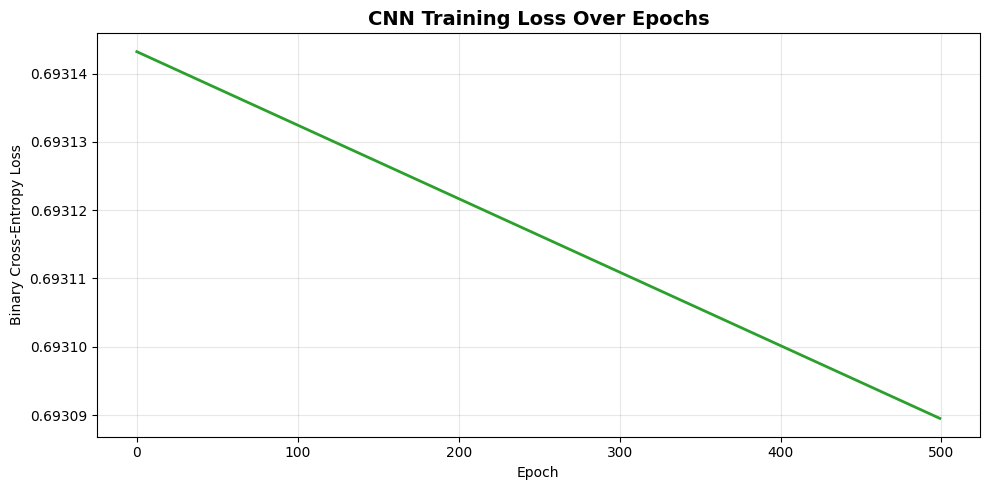

Final Loss: 0.6931


In [9]:
# Visualize training loss
plt.figure(figsize=(10, 5))
plt.plot(model.loss_history, linewidth=2, color='#2ca02c')
plt.title('CNN Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final Loss: {model.loss_history[-1]:.4f}")

## Model Evaluation & Predictions

In [10]:
# Make Predictions on Test Set
Y_pred_prob = model.predict(X_test)
predictions = (Y_pred_prob > 0.5).astype(int)

# Evaluate on Test Set
accuracy = np.mean(predictions.flatten() == Y_test)

# Calculate additional metrics
tp = np.sum((predictions.flatten() == 1) & (Y_test == 1))
tn = np.sum((predictions.flatten() == 0) & (Y_test == 0))
fp = np.sum((predictions.flatten() == 1) & (Y_test == 0))
fn = np.sum((predictions.flatten() == 0) & (Y_test == 1))

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("\n" + "=" * 60)
print("TEST SET EVALUATION METRICS")
print("=" * 60)
print(f"Accuracy:  {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("=" * 60)


TEST SET EVALUATION METRICS
Accuracy:  80.35%
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000


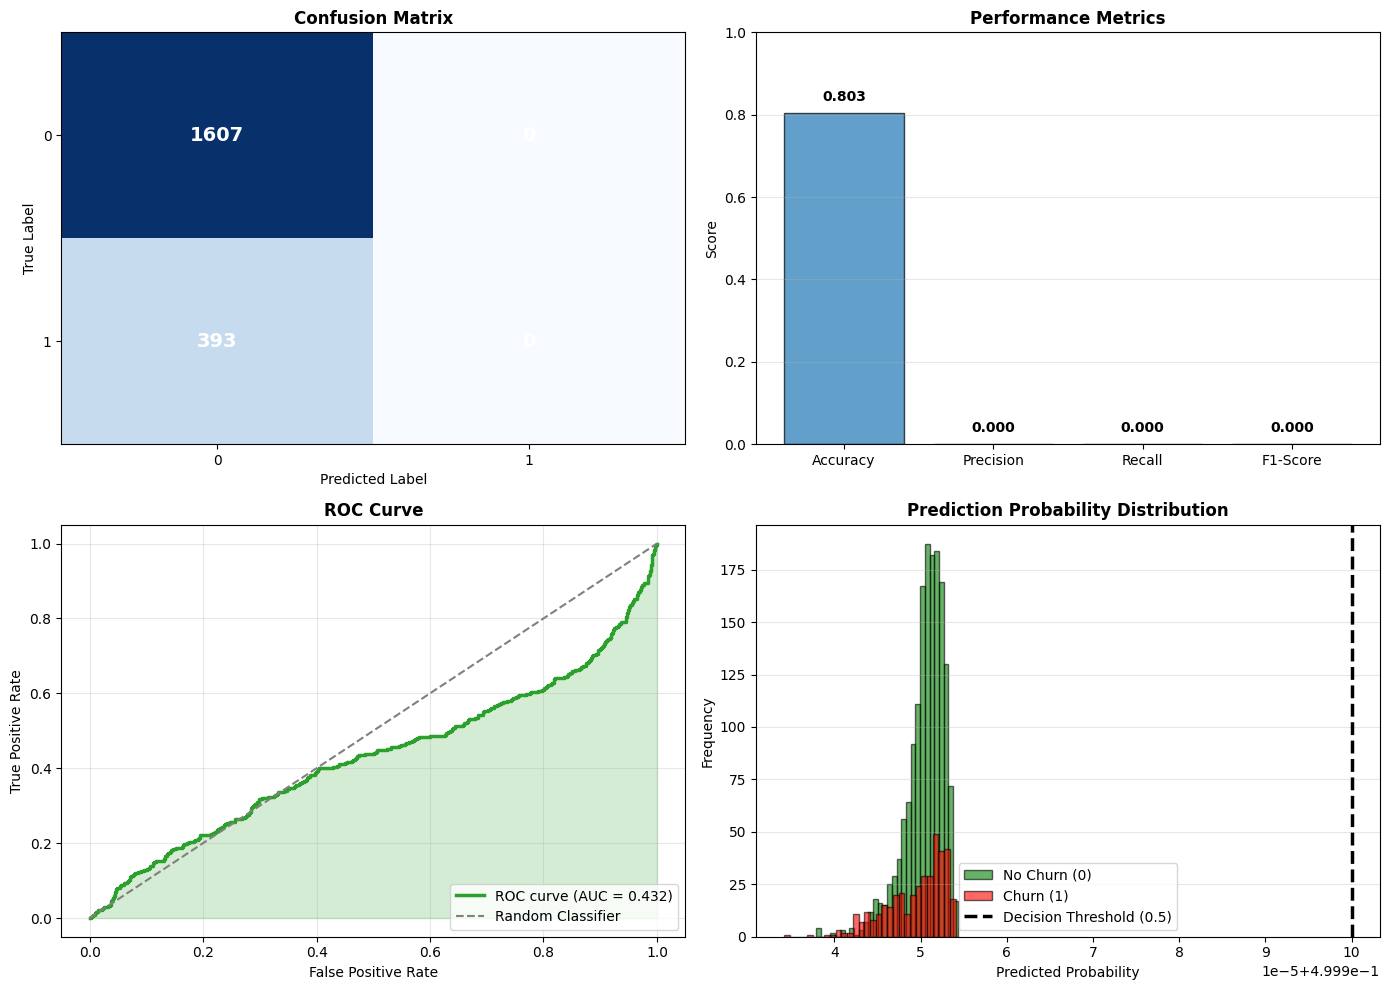


✓ AUC-ROC Score: 0.4316


In [11]:
# Comprehensive Visualization of Results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Confusion Matrix
cm = confusion_matrix(Y_test, predictions.flatten())
axes[0, 0].imshow(cm, cmap='Blues', aspect='auto')
axes[0, 0].set_title('Confusion Matrix', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')
axes[0, 0].set_xticks([0, 1])
axes[0, 0].set_yticks([0, 1])
for i in range(2):
    for j in range(2):
        axes[0, 0].text(j, i, str(cm[i, j]), ha='center', va='center', 
                       color='white', fontsize=14, fontweight='bold')

# 2. Metrics Bar Chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = axes[0, 1].bar(metrics, values, color=colors, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Performance Metrics', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_ylim([0, 1])
for i, v in enumerate(values):
    axes[0, 1].text(i, v + 0.03, f'{v:.3f}', ha='center', fontsize=10, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. ROC Curve
fpr, tpr, _ = roc_curve(Y_test, Y_pred_prob.flatten())
roc_auc = auc(fpr, tpr)
axes[1, 0].plot(fpr, tpr, color='#2ca02c', lw=2.5, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1, 0].plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--', label='Random Classifier')
axes[1, 0].fill_between(fpr, tpr, alpha=0.2, color='#2ca02c')
axes[1, 0].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].legend(fontsize=10, loc='lower right')
axes[1, 0].grid(True, alpha=0.3)

# 4. Prediction Distribution
axes[1, 1].hist(Y_pred_prob[Y_test == 0], bins=30, alpha=0.6, label='No Churn (0)', color='green', edgecolor='black')
axes[1, 1].hist(Y_pred_prob[Y_test == 1], bins=30, alpha=0.6, label='Churn (1)', color='red', edgecolor='black')
axes[1, 1].axvline(x=0.5, color='black', linestyle='--', linewidth=2.5, label='Decision Threshold (0.5)')
axes[1, 1].set_title('Prediction Probability Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n✓ AUC-ROC Score: {roc_auc:.4f}")